In [56]:
# Import Dependency
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    BaggingRegressor, 
    VotingRegressor, 
    StackingRegressor, 
    RandomForestRegressor, 
    ExtraTreesRegressor
)
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

In [26]:
# Initialize the path
trainFile = 'train.csv'
testFile = 'test.csv'

# load datasets by read_csv
loadTrain = pd.read_csv(trainFile)
loadTest = pd.read_csv(testFile)

In [60]:
# loadTrain.columns

Index(['id', 'Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

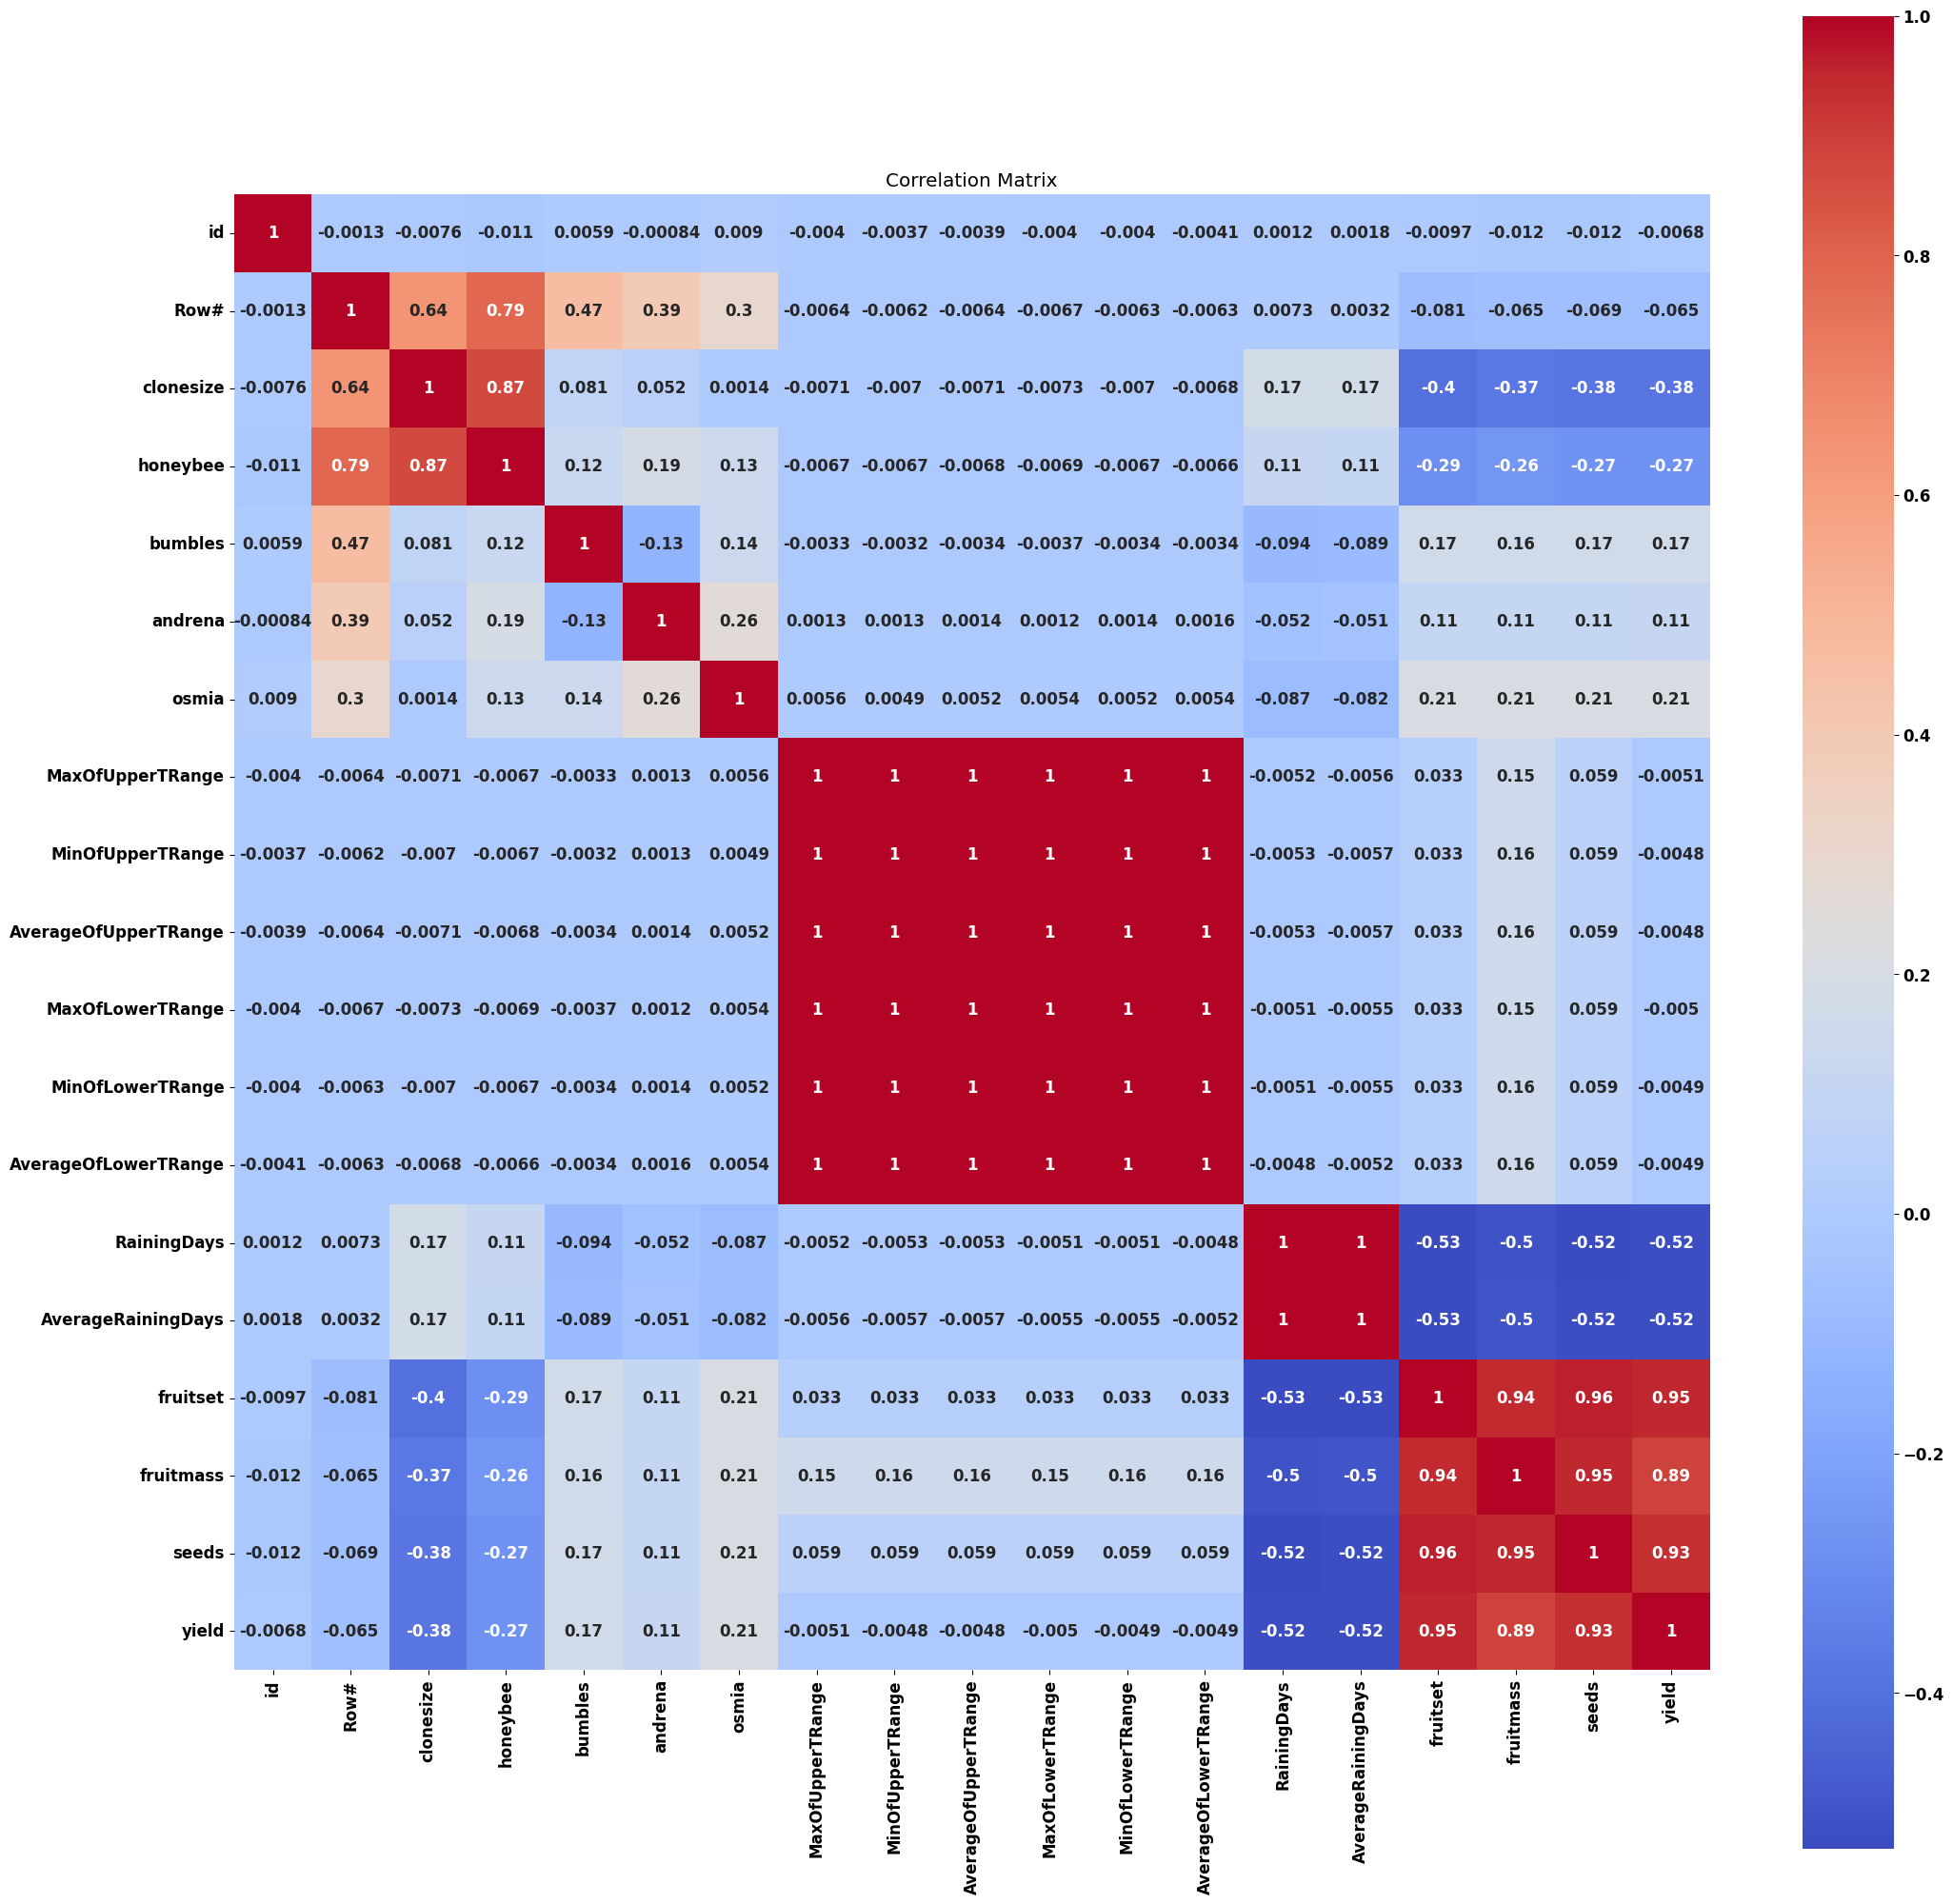

In [27]:
# Analyze Datasets and find relation among all the features
corr = loadTrain.corr('spearman')
# corr
# Visualize the correlation matrix
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

In [29]:
highCorr = ['seeds', 'fruitmass', 'fruitset']
modCorr = ['RainingDays', 'AverageRainingDays', 'clonesize', 'honeybee', 'Row#', 'bumbles']
lowCorr = ['andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']

In [42]:
def saveFile(yieldList, idList, modelName):
    predictYield = pd.DataFrame({
        'id': idList,
        'yield': yieldList
    })

    predictYield.to_csv(f'outputModel/YieldPredict_{modelName}.csv', index=False)

In [43]:
def selectFeatures():
    pass

In [44]:
def evalModel(model, xTestScaled, yTest):
    predictions = model.predict(xTestScaled)
    mse = mean_squared_error(yTest, predictions)
    mae = mean_absolute_error(yTest, predictions)
    r2 = r2_score(yTest, predictions)
    return mse, mae, r2

In [45]:
def testModel(model, modelName, xTestScaled, idTest):
    predictions = model.predict(xTestScaled)
    saveFile(predictions, idTest, modelName=modelName)
    

In [50]:
def trainModel(x, y, testData=None, idTest=None, testSize=.2, randomState=42, lRate=0.1):
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=testSize, random_state=randomState, shuffle=True)

    # Scaling the data
    scaler = StandardScaler()
    xTrainScaled = scaler.fit_transform(xTrain)
    yTestScaled = scaler.fit_transform(testData)
    xTestScaled = scaler.transform(xTest)

    # Select model type
    models = {
        'GradientBoosting': GradientBoostingRegressor(n_estimators=200, learning_rate=lRate, max_depth=5, random_state=randomState),
        'XGBoost': XGBRegressor(n_estimators=200, learning_rate=lRate, max_depth=5, random_state=randomState, eval_metric='mae'),
        'XGBRF': XGBRFRegressor(n_estimators=200, learning_rate=lRate, max_depth=5, random_state=randomState),
        'AdaBoost': AdaBoostRegressor(n_estimators=200, learning_rate=lRate, random_state=randomState),
        'Bagging': BaggingRegressor(n_estimators=200, random_state=randomState),
        'RandomForest': RandomForestRegressor(n_estimators=200, random_state=randomState),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=200, random_state=randomState),
        'Voting': VotingRegressor([('rf', RandomForestRegressor(n_estimators=200, random_state=randomState)),
                                   ('et', ExtraTreesRegressor(n_estimators=200, random_state=randomState))]),
        'Stacking': StackingRegressor(
            estimators=[('dt', DecisionTreeRegressor(max_depth=5)), ('ridge', Ridge())],
            final_estimator=RandomForestRegressor(n_estimators=200, random_state=randomState)
        )
    }

    # Train and evaluate each model
    for modelName, model in models.items():
        print(f"\nTraining {modelName} model...")
        model.fit(xTrainScaled, yTrain)
        
        mse, mae, r2 = evalModel(model, xTestScaled, yTest)
        print(f"{modelName} model performance:")
        print(f"  Mean Squared Error (MSE): {mse:.4f}")
        print(f"  Mean Absolute Error (MAE): {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")

        testModel(model, modelName, yTestScaled, idTest)


In [53]:
x = loadTrain[modCorr+highCorr]
y = loadTrain['yield']


trainModel(x, y, loadTest[modCorr+highCorr], loadTest['id'], testSize=.2, randomState=84, lRate=0.06)


Training GradientBoosting model...
GradientBoosting model performance:
  Mean Squared Error (MSE): 145112.2664
  Mean Absolute Error (MAE): 249.5675
  R² Score: 0.9214

Training XGBoost model...
XGBoost model performance:
  Mean Squared Error (MSE): 149226.5483
  Mean Absolute Error (MAE): 248.7227
  R² Score: 0.9191

Training XGBRF model...
XGBRF model performance:
  Mean Squared Error (MSE): 1648814.3072
  Mean Absolute Error (MAE): 1040.0581
  R² Score: 0.1064

Training AdaBoost model...
AdaBoost model performance:
  Mean Squared Error (MSE): 242015.1210
  Mean Absolute Error (MAE): 342.9646
  R² Score: 0.8688

Training Bagging model...
Bagging model performance:
  Mean Squared Error (MSE): 160382.0271
  Mean Absolute Error (MAE): 265.0994
  R² Score: 0.9131

Training RandomForest model...
RandomForest model performance:
  Mean Squared Error (MSE): 159949.5896
  Mean Absolute Error (MAE): 264.7231
  R² Score: 0.9133

Training ExtraTrees model...
ExtraTrees model performance:
  Mean

### ***CROSS VALIDATION***

In [57]:
# Evaluation metrics for cross-validation
def evalModelCV(model, x, y, cv=5):
    scoring = {
        'mse': make_scorer(mean_squared_error),
        'mae': make_scorer(mean_absolute_error),
        'r2': make_scorer(r2_score)
    }
    scores = cross_validate(model, x, y, cv=cv, scoring=scoring, return_train_score=False)
    mse = np.mean(scores['test_mse'])
    mae = np.mean(scores['test_mae'])
    r2 = np.mean(scores['test_r2'])
    return mse, mae, r2

# Save test predictions after model fitting
def testModel(model, modelName, xTestScaled, idTest):
    predictions = model.predict(xTestScaled)
    saveFile(predictions, idTest, modelName=modelName)

# Main model training function
def saveFile(yieldList, idList, modelName):
    # Ensure the lengths match before saving
    if len(yieldList) != len(idList):
        raise ValueError(f"Prediction length {len(yieldList)} does not match ID length {len(idList)}")
    
    predictYield = pd.DataFrame({
        'id': idList,
        'yield': yieldList
    })
    predictYield.to_csv(f'outputModel/YieldPredict_{modelName}.csv', index=False)

def trainModel(x, y, testData=None, idTest=None, testSize=.2, randomState=42, lRate=0.1, cv=5):
    # Split the dataset
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=testSize, random_state=randomState, shuffle=True)

    # Scale the data
    scaler = StandardScaler()
    xTrainScaled = scaler.fit_transform(xTrain)
    xTestScaled = scaler.transform(xTest)

    # Ensure testData and idTest lengths match
    if len(testData) != len(idTest):
        raise ValueError(f"Test data length {len(testData)} does not match ID length {len(idTest)}")

    testDataScaled = scaler.transform(testData)  # Scale the testData correctly

    # Define models
    models = {
        'GradientBoosting': GradientBoostingRegressor(n_estimators=120, learning_rate=lRate, max_depth=5, random_state=randomState),
        'XGBoost': XGBRegressor(n_estimators=120, learning_rate=lRate, max_depth=5, random_state=randomState, eval_metric='mae'),
        'XGBRF': XGBRFRegressor(n_estimators=200, learning_rate=lRate, max_depth=5, random_state=randomState),
        'AdaBoost': AdaBoostRegressor(n_estimators=200, learning_rate=lRate, random_state=randomState),
        'Bagging': BaggingRegressor(n_estimators=300, random_state=randomState),
        'RandomForest': RandomForestRegressor(n_estimators=200, random_state=randomState),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=200, random_state=randomState),
        'Voting': VotingRegressor([('rf', RandomForestRegressor(n_estimators=350, random_state=randomState)),
                                   ('et', ExtraTreesRegressor(n_estimators=350, random_state=randomState))]),
        'Stacking': StackingRegressor(
            estimators=[('dt', DecisionTreeRegressor(max_depth=5)), ('ridge', Ridge())],
            final_estimator=RandomForestRegressor(n_estimators=350, random_state=randomState)
        )
    }

    # Train and evaluate each model
    for modelName, model in models.items():
        print(f"\nTraining {modelName} model with {cv}-fold cross-validation...")

        # Cross-validated metrics
        mse, mae, r2 = evalModelCV(model, xTrainScaled, yTrain, cv=cv)
        print(f"{modelName} cross-validated performance:")
        print(f"  Mean Squared Error (MSE): {mse:.4f}")
        print(f"  Mean Absolute Error (MAE): {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")

        # Fit the model on the full training set
        model.fit(xTrainScaled, yTrain)

        # Test the model on the actual test data (testDataScaled) and save results
        testModel(model, modelName, testDataScaled, idTest)


# Example usage with your data
x = loadTrain[modCorr + highCorr]  # Feature columns
y = loadTrain['yield']             # Target variable (yield)

trainModel(x, y, loadTest[modCorr + highCorr], loadTest['id'], testSize=.2, randomState=42, lRate=0.06, cv=20)



Training GradientBoosting model with 75-fold cross-validation...
GradientBoosting cross-validated performance:
  Mean Squared Error (MSE): 149176.6429
  Mean Absolute Error (MAE): 249.3745
  R² Score: 0.9170

Training XGBoost model with 75-fold cross-validation...
XGBoost cross-validated performance:
  Mean Squared Error (MSE): 149334.1825
  Mean Absolute Error (MAE): 250.6455
  R² Score: 0.9169

Training XGBRF model with 75-fold cross-validation...
XGBRF cross-validated performance:
  Mean Squared Error (MSE): 1619575.2747
  Mean Absolute Error (MAE): 1032.3113
  R² Score: 0.0998

Training AdaBoost model with 75-fold cross-validation...
AdaBoost cross-validated performance:
  Mean Squared Error (MSE): 244587.5689
  Mean Absolute Error (MAE): 349.8038
  R² Score: 0.8640

Training Bagging model with 75-fold cross-validation...
Bagging cross-validated performance:
  Mean Squared Error (MSE): 158928.9496
  Mean Absolute Error (MAE): 260.1077
  R² Score: 0.9115

Training RandomForest mode